<a href="https://colab.research.google.com/github/chaos44/signate_competition/blob/main/off_road.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chaos44/signate_competition

fatal: destination path 'signate_competition' already exists and is not an empty directory.


In [1]:
cd signate_competition

/content/signate_competition


In [2]:
ls

ames.ipynb                off_road/       train_A1.zip
ames_kaggle.ipynb         off_road.ipynb  train_A2.zip
ames_kaggle_scaled.ipynb  precision.zip   train_A3.zip
ams_beginner/             README.md       tutorial_model.pkl
annotation_A.zip          train_A0.zip    tutorial_submission.json


In [3]:
import os
from glob import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
from PIL import Image
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

print(torch.__version__)
print(torch.cuda.is_available())

# 評価対象カテゴリ
eval_names = ('road','dirt road', 'other obstacle')
eval_colors = ((128, 64, 128), (255, 128, 128), (0, 0, 70))

1.7.0+cu101
True


## **1. データの読み込み**

データの読み込みを行います。
まずは「学習用画像」「学習用アノテーション」「精度評価用画像」のファイルパスをそれぞれ取得しましょう。

In [5]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)#2. Get the file
train_A0 = drive.CreateFile({'id':'1amBnDtdmfwe6E4fMsD-9XuJPac9H2bwI'}) # replace the id with id of file you want to access
train_A1 = drive.CreateFile({'id':'1wl_vj4UlECr9NkdpzeP6PUj8T66OICyH'})
train_A2 = drive.CreateFile({'id':'1unrPOKP2GH1LVhlwDh1ypZ3_Do5UibvX'})
train_A3 = drive.CreateFile({'id':'1_mNWROSr7IZ24SeGMBT2ECKKfSd0ABXj'})
annotation_A = drive.CreateFile({'id':'1fFShS85-VxdkhJt58ngJxnicP6W8e3ew'})
precision = drive.CreateFile({'id':'1MN8kwpPPN-BUsJKnrkiuofv8UdejY3ki'})
train_A0.GetContentFile('train_A0.zip')
train_A1.GetContentFile('train_A1.zip')
train_A2.GetContentFile('train_A2.zip')
train_A3.GetContentFile('train_A3.zip')
annotation_A.GetContentFile('annotation_A.zip')
precision.GetContentFile('precision.zip')

In [ ]:
!unzip -j train_A0.zip -d off_road/train_images_A
# !unzip -j train_A1.zip -d off_road/train_images_A
# !unzip -j train_A2.zip -d off_road/train_images_A
# !unzip -j train_A3.zip -d off_road/train_images_A
!unzip -j annotation_A.zip -d off_road/train_annotations_A
!unzip -j precision.zip -d off_road/precision_test_images

In [4]:
train_images_path_list = sorted(glob('off_road/train_images_A/*.png'))
train_annotations_path_list = sorted(glob('off_road/train_annotations_A/*.png'))
precision_test_images_path_list = sorted(glob('off_road/precision_test_images/*.png'))

print('================')
print('学習用画像: ')
print(len(train_images_path_list))
print(train_images_path_list[:5])
print('================')
print('学習用アノテーション: ')
print(len(train_annotations_path_list))
print(train_annotations_path_list[:5])
print('================')
print('精度評価用画像: ')
print(len(precision_test_images_path_list))
print(precision_test_images_path_list[:5])

学習用画像: 
750
['off_road/train_images_A/train_image_A0000.png', 'off_road/train_images_A/train_image_A0001.png', 'off_road/train_images_A/train_image_A0002.png', 'off_road/train_images_A/train_image_A0003.png', 'off_road/train_images_A/train_image_A0004.png']
学習用アノテーション: 
3007
['off_road/train_annotations_A/train_annotation_A0000.png', 'off_road/train_annotations_A/train_annotation_A0001.png', 'off_road/train_annotations_A/train_annotation_A0002.png', 'off_road/train_annotations_A/train_annotation_A0003.png', 'off_road/train_annotations_A/train_annotation_A0004.png']
精度評価用画像: 
640
['off_road/precision_test_images/precision_test_image_0000.png', 'off_road/precision_test_images/precision_test_image_0001.png', 'off_road/precision_test_images/precision_test_image_0002.png', 'off_road/precision_test_images/precision_test_image_0003.png', 'off_road/precision_test_images/precision_test_image_0004.png']


学習用データは、「画像」・「アノテーション」ともに10枚、
精度評価用の画像は10枚存在することを確認しました。

画像データの可視化

画像データの可視化を実行します。
上で取得したファイルパスを用いて画像データを読み込み、互いに対応する「画像」と「アノテーション」を横に並べて可視化してみましょう。


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


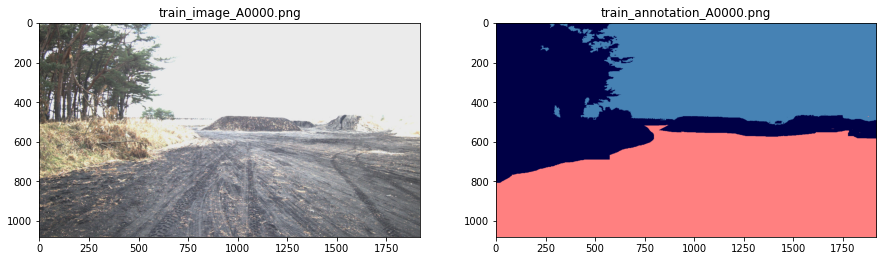

In [5]:
# 画像の読み込み
image_0000 = Image.open('off_road/train_images_A/train_image_A0000.png')
annotation_0000 = Image.open('off_road/train_annotations_A/train_annotation_A0000.png')

# 可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes[0].imshow(image_0000)
axes[0].set_title('train_image_A0000.png')

axes[1].imshow(annotation_0000)
axes[1].set_title('train_annotation_A0000.png')

plt.show()

各評価対象カテゴリが含まれる画像枚数の確認

各評価対象カテゴリに該当する物体(road, dirt road, other obstacle)は、全ての画像内に登場するとは限りません。
各カテゴリの物体が各画像にどれほどの頻度で登場しているのかについて、学習用アノテーション画像を対象に確認しましょう。

<BarContainer object of 3 artists>

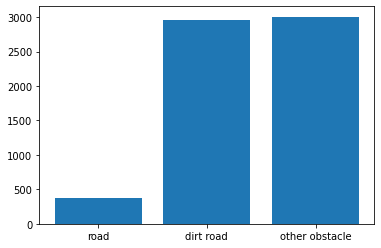

In [ ]:
count = {
    'road': 0,
    'dirt road': 0,
    'other obstacle':0
}

for train_annotation_path in train_annotations_path_list:
    image = np.array(Image.open(train_annotation_path))
    
    for eval_name, eval_color in zip(eval_names, eval_colors):
        mask = (image==eval_color).sum(axis=2)==3
        if np.any(mask):
            count[eval_name] += 1
            
plt.bar(count.keys(), count.values())


## **2. モデリング**

簡易的な手法を用いたモデリングを実施します。

前処理クラスの定義

前処理では、「画像の縮小」「テンソル化」「入力画像の標準化」「アノテーション画像の4カテゴリ表現への変換」などを行います。

In [6]:
class OffRoadTransform():
    def __init__(self, image_size, mean, std):
        self.image_size = image_size
        self.mean = mean
        self.std = std
        
    def __call__(self, image, annotation):
        
        # リサイズ
        image = image.resize((self.image_size[1], self.image_size[0]))        
        annotation = annotation.resize((self.image_size[1], self.image_size[0]))
        
        # テンソル化&標準化
        image = transforms.functional.to_tensor(image)
        image = transforms.functional.normalize(image, self.mean, self.std)
        
        # アノテーション画像の色(RGB)情報を以下のように対応するようマッピングし、2次元の配列に変換する
        """
        road(128, 64, 128) -> 1
        dirt road(255, 128, 128) -> 2
        other obstacle(0, 0, 70) -> 3
        上記以外 -> 0
        """
        annotation = np.array(annotation)
        converted_annotation = np.zeros(annotation.shape[:-1])
        for i, eval_color in enumerate(eval_colors):
            mask = (annotation==eval_color).sum(axis=2)==3
            converted_annotation[mask] = i+1
        annotation = torch.from_numpy(converted_annotation)
        
        return image, annotation


データセットの作成

torch.utils.data.Datasetクラスを継承したクラスを作成します。


In [7]:
class OffRoadDataset(data.Dataset):
    def __init__(self, image_list, annotation_list, transform):
        self.image_list = image_list
        self.annotation_list = annotation_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):

        image_filepath = self.image_list[index]
        annotation_filepath = self.annotation_list[index]
        
        image = Image.open(image_filepath)
        annotation = Image.open(annotation_filepath)

        image, annotation = self.transform(image, annotation)
        
        return image, annotation

In [8]:
train_dataset = OffRoadDataset(train_images_path_list, train_annotations_path_list,
                              transform=OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))

print(train_dataset.__getitem__(0)[0].shape)
print(train_dataset.__getitem__(0)[1].shape)

torch.Size([3, 270, 480])
torch.Size([270, 480])


 **データローダーの作成**

In [21]:
batch_size = 6
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

**モデルの初期化**

モデルの初期化を行います。
ここでは、torchvisionライブラリに標準で実装されているdeeplabv3_resnet101モデルを使用します。


In [10]:
net = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

当コンペティションの課題内容に合わせて、モデルの出力層のチャンネル数を変更しましょう。
3つの評価対象カテゴリ(「road」「dirt road」「other obstacle」)及び「その他」の合計4つのカテゴリに分類するということでチャンネル数は4に変更します。

In [11]:
net.classifier[-1] = nn.Conv2d(256, 4, kernel_size=(3, 3), stride=(1, 1))

 **損失関数、最適化手法の定義**

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters())


モデルの学習を実行する関数の定義

モデルの学習を実行する関数を定義しましょう。
全エポックの終了後に学習済みモデルのオブジェクトをpickleファイルとして保存するように設定します。


In [13]:
def train(net, train_dataloader, criterion, optimizer, n_epoch):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    net.to(device)
    net.train()

    for epoch in range(1, n_epoch+1):
        epoch_train_loss = 0.0
        optimizer.zero_grad()
        
        for images, annotations in train_dataloader:
            images = images.to(device)
            annotations = annotations.to(device)
            optimizer.step()
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = net(images)['out']
                loss = criterion(outputs, annotations.long())
                loss.backward()
                
        print(f'Epoch {epoch} finished')

    pd.to_pickle(net, "tutorial_model.pkl")

In [29]:
# 再学習
net = pd.read_pickle("tutorial_model.pkl")


 **学習の実行**

モデルの学習を実行します。


In [30]:
train(net, train_dataloader, criterion, optimizer, n_epoch=20)

cuda:0
Epoch 1 finished
Epoch 2 finished
Epoch 3 finished
Epoch 4 finished
Epoch 5 finished
Epoch 6 finished
Epoch 7 finished
Epoch 8 finished
Epoch 9 finished
Epoch 10 finished
Epoch 11 finished
Epoch 12 finished
Epoch 13 finished
Epoch 14 finished
Epoch 15 finished
Epoch 16 finished
Epoch 17 finished
Epoch 18 finished
Epoch 19 finished
Epoch 20 finished



 **推論結果の可視化**

学習済みのモデルを用いて推論を実行しましょう。
また、元画像と推論の結果生成された画像を並べて可視化することで、モデルの学習が上手くいっているのかを確認してみましょう。


In [31]:
# 学習済みモデルの読み込み
net = pd.read_pickle("tutorial_model.pkl")

Text(0.5, 1.0, '予測結果')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20803 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30011 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20687 missing from current font.
  font.set_text

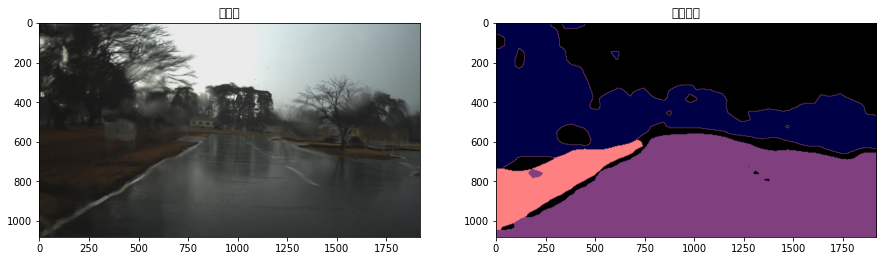

In [32]:
# デバイスの設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()

# 前処理クラスのインスタンス化
test_transform = OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# 画像データの読み込み
test_image_0000 = Image.open('off_road/precision_test_images/precision_test_image_0010.png')
dummy_annotation = Image.open('off_road/train_annotations_A/train_annotation_A0000.png')

image_transformed, _ = test_transform(test_image_0000, dummy_annotation)
image_transformed = image_transformed.unsqueeze(0)
image_transformed = image_transformed.to(device)

# 推論の実行
prediction = net(image_transformed)['out']
prediction = prediction[0].to('cpu').detach().numpy()
prediction = np.argmax(prediction, axis=0).astype('uint8')
prediction = np.array(Image.fromarray(prediction).resize([1920, 1080]))

# 推論結果をRGB画像に変換
RGB = np.zeros([1080, 1920, 3], dtype='uint8')
for i, color in enumerate(eval_colors):
    mask = prediction==i+1
    RGB[mask] = color
RGB_prediction = np.array(Image.fromarray(RGB).resize([1920, 1080]))

# 可視化
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes[0].imshow(test_image_0000)
axes[0].set_title('元画像')

axes[1].imshow(RGB_prediction)
axes[1].set_title('予測結果')


# **3. 提出物の作成**

各部門ごとに提出物の作成方法を確認しましょう
当コンペティションでは、両部門ともに予測値を辞書形式のフォーマットに変換する必要があります。
まずは、アノテーション画像を提出フォーマットに則った辞書形式に変換する関数pred2dictを定義しましょう。


In [24]:
def pred2dict(fname, prediction):
    categories = [('road',[128, 64, 128]),('dirt road',[255, 128, 128]),('other obstacle',[0, 0, 70])]
    pred_dict = {}
    pred_dict[fname]={}
    
    for i,category in enumerate(categories):

        category_segments_pred = {}
        x_pred, y_pred = np.where(prediction==(i+1))
        category_pix_pred = {}

        for i,j in zip(x_pred,y_pred):
            if i not in category_pix_pred:
                category_pix_pred[i]=[]
            category_pix_pred[i].append(j)   

        for l in category_pix_pred:
            segments = []
            num_segments = 0
            for i,v in enumerate(sorted(category_pix_pred[l])):
                if i==0:
                    start=v
                    end=v
                else:
                    if v==end+1:
                        end = v
                    else:
                        segments.append([int(start),int(end)])
                        start = v
                        end = v
                        num_segments+=1
            segments.append([int(start),int(end)])
            category_segments_pred[int(l)]=segments
        if len(category_pix_pred):
            pred_dict[fname][category[0]]=category_segments_pred
        
    return pred_dict


 **A. 認識精度部門**

認識精度部門の提出物作成方法を説明します。
「学習済みモデルを用いて予測画像を生成->予測画像を提出フォーマットに変換する」という処理を予測対象画像640枚に対して1枚ずつ実行し、それらを統合した辞書オブジェクトをJSON形式のファイルとして保存します。


In [25]:
def make_submission_file():
    
    categories = [('road',[128, 64, 128]),('dirt road',[255, 128, 128]),('other obstacle',[0, 0, 70])]
    predictions = {}
    
    # デバイスの設定
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)
    
    net.eval()
    
    # 前処理クラスのインスタンス化
    test_transform = OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    
    # 画像一枚ずつに対して処理を実行するループ
    for test_image_path in precision_test_images_path_list:
        
        fname = os.path.basename(test_image_path)
        test_image = Image.open(test_image_path)
        dummy_annotation = Image.open('off_road/train_annotations_A/train_annotation_A0000.png')
        test_image, _ = test_transform(test_image, dummy_annotation)
        
        # ミニバッチ化
        test_image = test_image.unsqueeze(0).to(device)
        
        # 推論の実行
        prediction = net(test_image)['out']
        prediction = prediction[0].to('cpu').detach().numpy()
        prediction = np.argmax(prediction, axis=0).astype('uint8')
        prediction = np.array(Image.fromarray(prediction).resize([1920, 1080]))
        
        # 関数pred2dictを用いて予測画像を辞書形式に変換
        pred_dict = pred2dict(fname, prediction)
        predictions.update(pred_dict)

    with open(f'tutorial_submission.json', 'w') as f:
        json.dump(predictions, f)

In [33]:
make_submission_file()


B. 推論速度部門

推論速度部門の提出物作成方法について説明します。
まずは以下のようにサンプル提出ファイル(sample_submission.zip)と同様のディレクトリ構成を再現しましょう。
modelディレクトリの中に学習済みモデル(tutorial_model.pkl)、srcディレクトリの中に推論を実行するPythonスクリプト(predictor.py)を格納しています。

    tutorial_submission/
        model/
            tutorial_model.pkl
        requirements.txt
        src/
            predictor.py

ScoringServiceクラスの実装

predictor.pyにおいて定義するScoringServiceクラスの実装例を記載します。
ScoringServiceは以下2つのメソッドを定義する必要があります。

    get_model: モデルを読み込むメソッド
    predict: 評価用画像1枚を読み込み、その予測結果を返り値とするメソッド



In [ ]:
class ScoringService(object):
    @classmethod
    def get_model(cls, model_path='../model'):
        # cls.modelに学習済みモデルを読み込む
        cls.model = pd.read_pickle(model_path+'/tutorial_model.pkl')
        return True

    @classmethod
    def predict(cls, input):
        # ファイルパスを示すinputからファイル名のみを抽出する
        fname = os.path.basename(input)
        categories = [('road',[128, 64, 128]),('dirt road',[255, 128, 128]),('other obstacle',[0, 0, 70])]
    
        # デバイスの設定
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        net.to(device)
        net.eval()

        # 前処理クラスのインスタンス化
        test_transform = OffRoadTransform(image_size=(270, 480), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        
        # 評価用画像の読み込み
        test_image = Image.open(filepath)
        test_image, _ = test_transform(test_image, test_image)

        # ミニバッチ化
        test_image = test_image.unsqueeze(0).to(device)

        # 推論の実行
        prediction = net(test_image)['out']
        prediction = prediction[0].to('cpu').detach().numpy()
        prediction = np.argmax(prediction, axis=0).astype('uint8')
        prediction = np.array(Image.fromarray(prediction).resize([1920, 1080]))

        # 関数pred2dictを用いて予測画像を辞書形式に変換
        pred_dict = pred2dict(fname, prediction)

        # 1枚の画像に対する予測値を返り値とする
        return pred_dict


 **提出物のZIPファイル化**

推論速度部門の提出物はZIPファイルである必要があります。
以下のようなコマンドを実行し、「tutorial_submission」ディレクトリをZIP化した上で、ファイルを提出しましょう。

zip -r tutorilal_submission.zip tutorial_submission



In [ ]:
!zip -r tutorilal_submission.zip tutorial_submission

	zip warning: name not matched: tutorial_submission

zip error: Nothing to do! (try: zip -r tutorilal_submission.zip . -i tutorial_submission)



## **4. 評価スコア改善に向けて**

前述したソースコードはごく簡易的な手法を用いているので、工夫次第で更に評価値が改善する余地があります。
以下に、評価改善のための工夫例をいくつか提示します。

    認識精度改善のための工夫例
        検証データを利用した最適なパラメータの探索
        より高性能なネットワークの採用
        データオーギュメンテーション(データ水増し)の実行
        画像の拡大・縮小のサイズや手法の変更
        損失関数・最適化手法の変更
        複数モデルを用いたアンサンブル
    推論速度改善のための工夫例
        ネットワークの軽量化
        推論実行時の画像サイズの縮小
        推論時のデータ水増しやアンサンブルを使用しない
        その他 前処理、後処理を含むソースコードの最適化

当チュートリアルは以上となります。
皆様のご参加をお待ちしています。
